#  Прогнозирование заказов такси

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Строится модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

# План

**1. Загрузка данных и их ресемплирование по одному часу.**

**2. Анализ данных.**

**3. Обучение разных моделей с различными гиперпараметрами.**

**4. Проверка данных на тестовой выборке.**

**5. Выводы.**

## Загрузка данных и их ресемплирование по одному часу

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

### Загрузим данные

In [2]:
taxi_data = pd.read_csv('/datasets/taxi.csv')
taxi_data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Пропусков в данных нет.

### Проверим данные на наличие дубликатов

In [4]:
taxi_data.duplicated().sum()

0

Дубликатов нет.

### Выполним ресемплирование данных по 1 часу

In [5]:
taxi_data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi_data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
taxi_data.sort_index(inplace=True)
taxi_data = taxi_data.resample('1H').sum()
taxi_data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

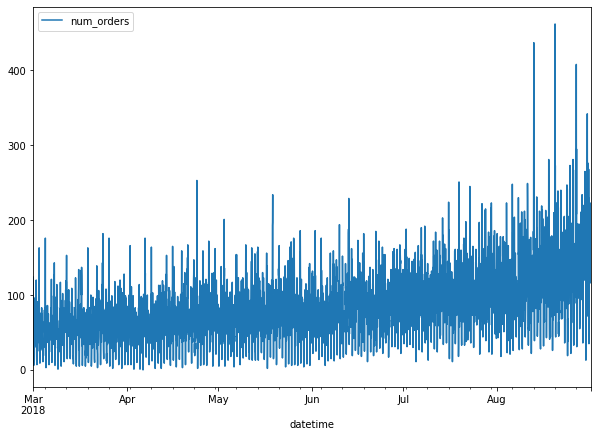

In [8]:
taxi_data.plot(figsize=(10,7));

По графику построенному на всех данных сложно выявить закономерности. Посторим графики тренда и сезонности.

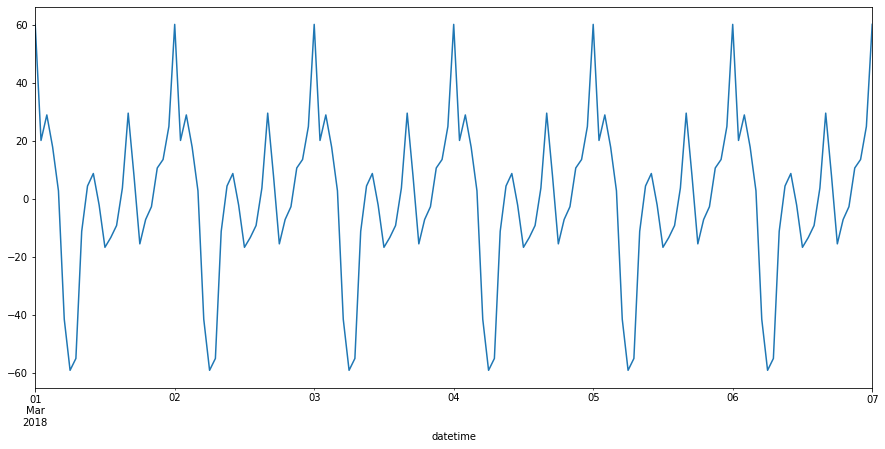

In [9]:
decomposed = seasonal_decompose(taxi_data)
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-07 00:00:00'].plot(figsize=(15,7));

Итак пографику сезонности видно, что есть пик по кол-ву заказов такси в полночь и в 16:00-17:00.

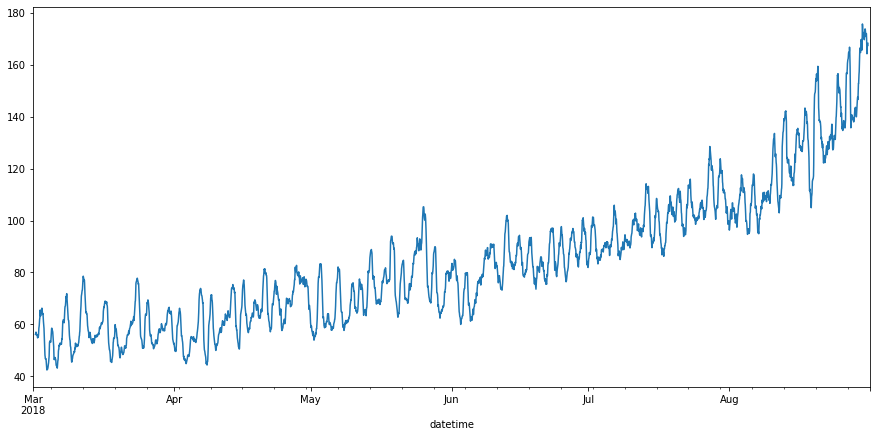

In [10]:
decomposed.trend.plot(figsize=(15,7));

График тренда показывает, что со временем кол-во заказов такси растет.

### Добавим признаки: месяц, день недели, день, час, отстающие значения и скользящее среднее

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [12]:
make_features(taxi_data, 24, 24)
taxi_data.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Обучение

In [13]:
train, ost = train_test_split(taxi_data, shuffle=False, test_size=0.2)
train = train.dropna()
valid, test = train_test_split(ost, shuffle=False, test_size=0.5)

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']
features_valid = valid.drop('num_orders', axis=1)
target_valid = valid['num_orders']

### Построим модель линейной регрессии

In [14]:
linear_model = LinearRegression().fit(features_train, target_train)
linear_predict = linear_model.predict(features_valid)
mean_squared_error(target_valid, linear_predict) ** 0.5

34.15452226495236

### Построим модель дерева решений

In [15]:
best_tree_model = DecisionTreeRegressor(random_state=12345, max_depth=1)
best_depth1 = 0
best_rmse1 = 100

i_depth = [None] + [i for i in range(2, 7)]

for i in i_depth:
    
    tree_model = DecisionTreeRegressor(random_state=12345, max_depth=i).fit(features_train, target_train)
    tree_predict = tree_model.predict(features_valid)
    rmse = mean_squared_error(target_valid, tree_predict) ** 0.5
    print('depth:', i, 'rmse:', rmse)
    
    if rmse < best_rmse1:
        best_tree_model = tree_model
        best_depth1 = i
        best_rmse1 = rmse

print()
print('depth:', best_depth1, 'rmse:', best_rmse1)

depth: None rmse: 44.05898966312944
depth: 2 rmse: 45.43095291282149
depth: 3 rmse: 43.436300598620576
depth: 4 rmse: 41.26138784749863
depth: 5 rmse: 38.409271134535
depth: 6 rmse: 37.22642327018365

depth: 6 rmse: 37.22642327018365


### построим модель случайного леса

In [16]:
best_forest_model = RandomForestRegressor(random_state=12345, n_estimators=1, max_depth=1)
best_est = 0
best_depth2 = 0
best_rmse2 = 100

for est in range(100, 151, 50):
    for depth in i_depth:
        forest_model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth).fit(features_train, target_train)
        forest_predict = forest_model.predict(features_valid)
        rmse = mean_squared_error(target_valid, forest_predict) ** 0.5
        print('est:', est, 'depth:', depth, 'rmse:', rmse)
        if rmse < best_rmse2:
            best_forest_model = forest_model
            best_est = est
            best_depth2 = depth
            best_rmse2 = rmse
        
print()
print('est:', best_est, 'depth:', best_depth2, 'rmse:', best_rmse2)

est: 100 depth: None rmse: 31.953764413304974
est: 100 depth: 2 rmse: 44.543317350454025
est: 100 depth: 3 rmse: 42.33694255853554
est: 100 depth: 4 rmse: 39.59433116364446
est: 100 depth: 5 rmse: 37.32795996693212
est: 100 depth: 6 rmse: 35.41288360765323
est: 150 depth: None rmse: 32.02972608753993
est: 150 depth: 2 rmse: 44.43789478069827
est: 150 depth: 3 rmse: 42.35686529867893
est: 150 depth: 4 rmse: 39.59180816664569
est: 150 depth: 5 rmse: 37.28947334333391
est: 150 depth: 6 rmse: 35.51153339175364

est: 100 depth: None rmse: 31.953764413304974


### константная модель

In [17]:
dummy_model = DummyRegressor(strategy="mean").fit(features_train, target_train)
dummy_predict = dummy_model.predict(features_test)
mean_squared_error(target_test, dummy_predict) ** 0.5

87.57804156155322

Выберем модель линейной регрессии.

## Тестирование

In [18]:
predict = linear_model.predict(features_test)
mean_squared_error(target_test, predict) ** 0.5

46.47889291054053

## Выводы

В ходе исследования была проделана следующая работа:

- данные были проверены на наличие пропусков, их не было обнаружено;
- дубликаты не обнаружены;
- выполнено ресемплирование данных по 1 часу;
- проведен анализ данных. По графику сезонности видно, что есть пик по кол-ву заказов такси в полночь и в 16:00-17:00. График тренда показывает, что со временем кол-во заказов такси растет;
- для прогноза были построены следующие модели: модель линейной регрессии, rmse - 34.1, модель дерева решений - 37.2, модель случайного леса - 32. Мы выбрали модель линейной регрессии. При тестировании она показала rmse - 46.5.
- Также была проверена константная модель, она показала rmse 87.5.